<a href="https://colab.research.google.com/github/bbchen33/Insight-project/blob/master/Job_title_classification_by_description" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use job description/skills to cluster job titles

Original dataset is from Kaggle https://www.kaggle.com/madhab/jobposts.

In [0]:
import pandas as pd
job_posts_labeled = pd.read_csv('job_posts_labeled_all_labeled.txt', sep = '\t')

In [0]:
job_posts_labeled = job_posts_labeled.dropna(subset=['various job'])

The official job titles are the ones in job_titles (either handlabled or just have the exactly same job titles). The 'various job' column is a list of possible job titles associated with the 'official job'.

In [0]:
job_posts_labeled[job_posts_labeled['official job']!= job_posts_labeled['various job']][:5]

,various job,official job,Company,JobDescription,JobRequirment,RequiredQual
1,News Editor,Editor,BlogNews.am,BlogNews.am is looking for a News Editor. He/ ...,NaN,- At least Bachelor's degree in Journalism or ...
2,HR Assistant,HR specialist,Career Center,We have a new opening for the position of HR A...,Main duties include but are not limited to the...,- Relevant graduate degree;\r\n- Fluent writte...
3,HR Assistant,HR specialist,Career Center,We have a new opening for the position of HR A...,Main duties include but are not limited to the...,- Relevant graduate degree;\r\n- Fluent writte...
4,HR Assistant,HR specialist,Career Center,We have a new opening for the position of HR A...,Main duties include but are not limited to the...,- Relevant graduate degree;\r\n- Fluent writte...
5,HR Coordinator,HR specialist,AtTask,AtTask has an opening for an HR Coordinator in...,- Assist US based Human Resource Team with bas...,- University degree in related field;\r\n- At ...


In [0]:
job_posts_features = job_posts_labeled[['various job','official job','JobDescription']]

Below is a list of job titles I found to be more abundant in the data I am working with so I will use them as the labels to categorize the rest of the job titles. Original dataset is from Kaggle https://www.kaggle.com/madhab/jobposts.

In [0]:
job_titles = 'accountant, bartender, chef, chief financial officer, civil engineer, editor, research assistant, marketing specialist, salesperson, software developer, software engineer, data scientist, volunteer, lawyer, graphic designer, ceo, it specialist, project manager, product manager, technical writer, journalist, medical doctor, pharmacist, translator, qa engineer, receptionist/ administrative assistant, recruiter, hr specialist, secretary, java developer, web developer, foreign language teacher, tour guide, president, mechanical engineer, electrical engineer, driver, professor, copywriter, intern, financial analyst, general manager, procurement specialist, sales manager, insurance agent, medical representative, credit officer, database developer, deputy manager, real estate agent, data entry clerk, ai engineer'

In [0]:
job_titles = job_titles.split(', ')
len(job_titles)

52

In [0]:
job_posts_features['official job'] = job_posts_features['official job'].str.lower()
job_posts_features['various job'] = job_posts_features['various job'].str.lower()

In [0]:
index_list = []
for job in job_titles:
  job_index = job_posts_features[job_posts_features['official job'] == job].index
  if len(job_index) >= 15:
    index_list.append(job_index)

Only 34 out of 52 job titles occur greater or equal to 15 times in this dataframe.

In [0]:
len(index_list)

34

In [0]:
import numpy as np
index_combined = np.concatenate(index_list)

In [0]:
len(index_combined)

2025

These jobs have titles identical to the ones I handlabeled (a total of 2111 jobs) so I can use job description as the feature and job titles as the label for training.

I called the ones with exactly the same labels as the handlabeled titles "labeled_df" while the rest as "unlabeled_df".

In [0]:
labeled_df = job_posts_features[['various job','official job', 'JobDescription']]
labeled_df = labeled_df.iloc[index_combined]
labeled_df = labeled_df.reset_index(drop = True)

In [0]:
unlabeled_df = job_posts_features[['various job','official job', 'JobDescription']]
unlabeled_df = unlabeled_df[~unlabeled_df.index.isin(index_combined)]
unlabeled_df = unlabeled_df.reset_index(drop = True)

In [0]:
combined_df = pd.concat([labeled_df, unlabeled_df], axis = 0)

In [0]:
combined_df = combined_df.reset_index(drop = True)

Cleaning the job description with text processing.

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
pd.options.mode.chained_assignment = None # Turning off warning
def text_processing(text):
  stemmer = SnowballStemmer('english')
  text = re.sub(r'([0-9]+?)', '', text) 
  text = re.sub(r'  ', ' ', text)
  text = re.sub(r'   ', ' ', text)
  text = re.sub(r'(!|"|#|\$|%|&|\'|\(|\)|\*|\+|,|-|\.|/|:|;|<|=|>|\?|@|\[|\\|\]|\^|_|`|{|\||}|~)+', ' ', text)
  text = text.lower()
  text = stemmer.stem(text)
  text = text.strip()
  text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
  return ' '.join(text)

def clean_description(job_description):
  job_description = job_description.apply(lambda x:text_processing(x))
  return job_description

In [0]:
combined_df['JobDescription'] = clean_description(combined_df['JobDescription'])

In [0]:
combined_df['JobDescription']

0        sef international growing universal credit org...
1        accountant full time national staff position b...
2        armenian forests ngo funding tufenkian foundat...
3        qsi international school yerevan seeks candida...
4        responsible accountancy financial management c...
                               ...                        
15085    youth facility educator main care person young...
15086    sos childrens villages armenian charity founda...
15087    program manager charge work partnership one pr...
15088    eu partner projects altacode ltd looking highl...
15089    position provide direct technical clinical pro...
Name: JobDescription, Length: 15090, dtype: object

Using zeugma to embed the texts inside JobDescription.

In [0]:
!pip install zeugma

  Created wheel for zeugma: filename=zeugma-0.46-cp36-none-any.whl size=8611 sha256=fe1e3f5a28fea023166b17c92dd8644dd1fb384813291db39c2d54600f04976a
  Stored in directory: /root/.cache/pip/wheels/49/ce/d3/22bc15de9112558b220d9dba3bfcd7d9ad0d8cc4d44d3e7813
Successfully built zeugma


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from zeugma.embeddings import EmbeddingTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer('english')

training_length = len(labeled_df)

transformer = EmbeddingTransformer('word2vec')
combined_X = transformer.transform(combined_df['JobDescription'])
#combined_X = vectorizer.fit_transform(combined_df['JobDescription'])
le = LabelEncoder()
y = le.fit_transform(combined_df['official job'][:training_length])
X_train, X_test, y_train, y_test = train_test_split(combined_X[:training_length], y, test_size = 0.3)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
from sklearn.svm import SVC
clf = SVC(probability = True)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.837171052631579

In [0]:
y_prediction = clf.predict(X_test)

In [0]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_prediction)

In [0]:
cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]

In [0]:
for i in range(34):
  for j in range(34):
    if cm[i,j] >= 0.5 and i != j:
      print(i,j)
    

5 29
27 26


The 'database developer' and 'software developer' have similar job descriptions. 'Sales manager' and 'salesperson' have similar job content. 

In [0]:
le.inverse_transform([5,29])

array(['database developer', 'software developer'], dtype=object)

In [0]:
le.inverse_transform([26,27])

array(['sales manager', 'salesperson'], dtype=object)

In [0]:
classes = le.inverse_transform(np.arange(34))

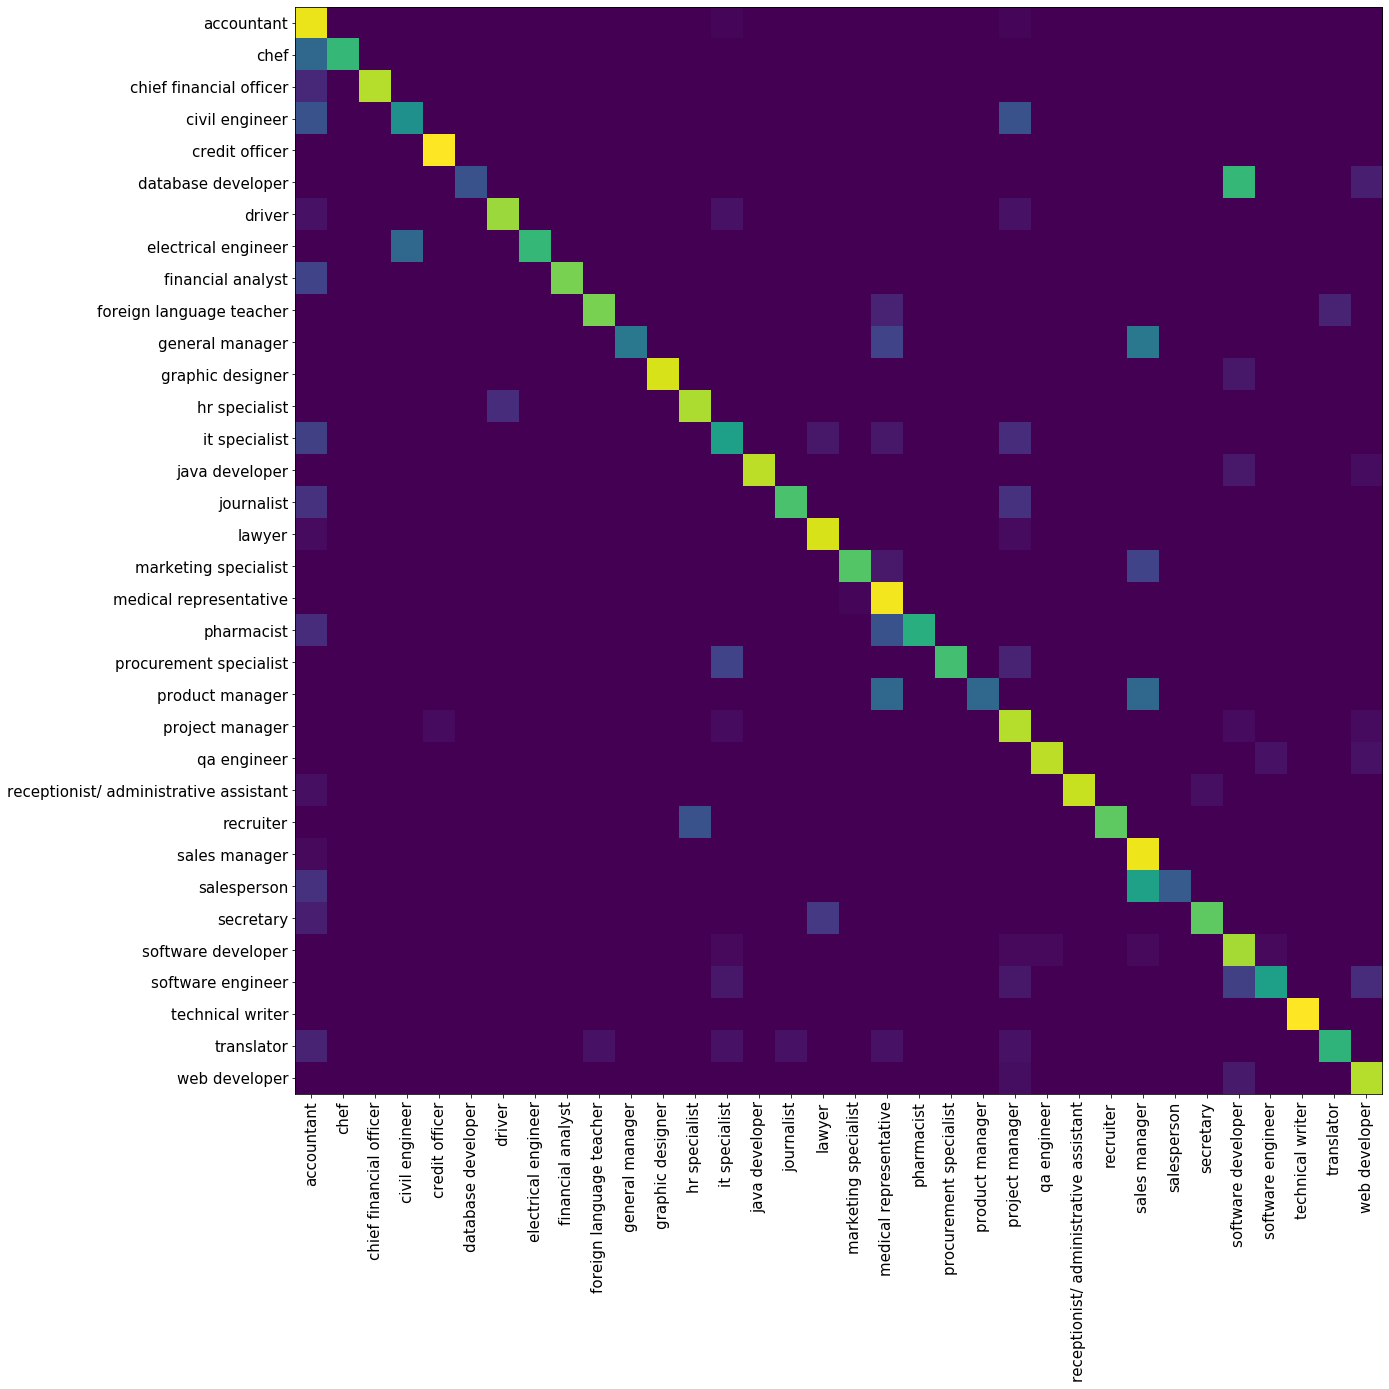

In [0]:
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest')
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation = 90)
plt.yticks(tick_marks, classes)
plt.rcParams.update({'font.size': 20})

In [0]:
from sklearn.model_selection import GridSearchCV

SVC_model = SVC()
param_range = np.logspace(-3, 2, 6)
param_grid = [
              {'C':param_range,
                'kernel':['rbf'],
                'gamma':param_range}
]
gs = GridSearchCV(estimator = SVC_model,
                  param_grid = param_grid,
                  scoring = 'accuracy',
                  cv = 2,
                  n_jobs = -1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  % (min_groups, self.n_splits)), UserWarning)


0.8375138893472832


The job prediction based on job description is 88% accurate. It's pretty good but I'll use only the ones with > 80% probability to get classified into any group by SVC.

In [0]:
X_test_good = X_test[clf.predict_proba(X_test).max(axis = 1) > 0.7]
y_test_good = y_test[clf.predict_proba(X_test).max(axis = 1) > 0.7]

In [0]:
clf.score(X_test_good, y_test_good)

0.9820359281437125

In [0]:
above_70_index = combined_df['official job'][training_length:][clf.predict_proba(combined_X[training_length:]).max(axis = 1) > 0.7].index

In [0]:
len(above_70_index)

1540

In [0]:
title_output_df = pd.DataFrame(columns = ['various job', 'predicted official job','JobDescription'])

prediction = le.inverse_transform(clf.predict(combined_X[training_length:]))[above_70_index-training_length]
various_title = combined_df['various job'][above_70_index].values
job_description = combined_df['JobDescription'][above_70_index].values

In [0]:
title_output_df['various job'] = various_title
title_output_df['predicted official job'] = prediction
title_output_df['JobDescription'] = job_description

Since the classification gets confused with database developer and software developer, let's just re-label database developer as software developer and see if the model can do well. 

In [0]:
dd_index = title_output_df[title_output_df['predicted official job'] == 'database developer'].index

In [0]:
title_output_df['predicted official job'][dd_index] = 'software developer'

In [0]:
len(title_output_df[title_output_df['predicted official job'] == 'sales manager'].index)

198

In [0]:
len(title_output_df[title_output_df['predicted official job'] == 'salesperson'].index)

11

In [0]:
sp_index = title_output_df[title_output_df['predicted official job'] == 'salesperson'].index

In [0]:
title_output_df['predicted official job'][sp_index] = 'sales manager'

Let's take the entire dataset and test it to see how well the model can perform classification on it.

In [0]:
feature = transformer.transform(title_output_df['JobDescription'])
new_y_prediction = clf.predict(feature)

In [0]:
from sklearn.metrics import accuracy_score
print(accuracy_score(le.inverse_transform(new_y_prediction), title_output_df['predicted official job']))

0.9896103896103896
